In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
!pip install pyarrow

'pip' is not recognized as an internal or external command,
operable program or batch file.


In [3]:
crashes_url = 'https://data.cityofnewyork.us/api/views/h9gi-nx95/rows.csv?accessType=download'
df_crashes= pd.read_csv(crashes_url, low_memory= False)


In [4]:
persons_url = 'https://data.cityofnewyork.us/api/views/f55k-p6yu/rows.csv?accessType=download'
df_persons = pd.read_csv(persons_url, low_memory = False)


In [5]:
df_crashes.head()

,CRASH DATE,CRASH TIME,BOROUGH,ZIP CODE,LATITUDE,LONGITUDE,LOCATION,ON STREET NAME,CROSS STREET NAME,OFF STREET NAME,...,CONTRIBUTING FACTOR VEHICLE 2,CONTRIBUTING FACTOR VEHICLE 3,CONTRIBUTING FACTOR VEHICLE 4,CONTRIBUTING FACTOR VEHICLE 5,COLLISION_ID,VEHICLE TYPE CODE 1,VEHICLE TYPE CODE 2,VEHICLE TYPE CODE 3,VEHICLE TYPE CODE 4,VEHICLE TYPE CODE 5
0,09/11/2021,2:39,NaN,NaN,NaN,NaN,NaN,WHITESTONE EXPRESSWAY,20 AVENUE,NaN,...,Unspecified,NaN,NaN,NaN,4455765,Sedan,Sedan,NaN,NaN,NaN
1,03/26/2022,11:45,NaN,NaN,NaN,NaN,NaN,QUEENSBORO BRIDGE UPPER,NaN,NaN,...,NaN,NaN,NaN,NaN,4513547,Sedan,NaN,NaN,NaN,NaN
2,11/01/2023,1:29,BROOKLYN,11230,40.62179,-73.970024,"(40.62179, -73.970024)",OCEAN PARKWAY,AVENUE K,NaN,...,Unspecified,Unspecified,NaN,NaN,4675373,Moped,Sedan,Sedan,NaN,NaN
3,06/29/2022,6:55,NaN,NaN,NaN,NaN,NaN,THROGS NECK BRIDGE,NaN,NaN,...,Unspecified,NaN,NaN,NaN,4541903,Sedan,Pick-up Truck,NaN,NaN,NaN
4,09/21/2022,13:21,NaN,NaN,NaN,NaN,NaN,BROOKLYN BRIDGE,NaN,NaN,...,Unspecified,NaN,NaN,NaN,4566131,Station Wagon/Sport Utility Vehicle,NaN,NaN,NaN,NaN


In [6]:

print(df_crashes.shape)

(2221796, 29)


In [7]:
print(df_crashes.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2221796 entries, 0 to 2221795
Data columns (total 29 columns):
 #   Column                         Dtype  
---  ------                         -----  
 0   CRASH DATE                     object 
 1   CRASH TIME                     object 
 2   BOROUGH                        object 
 3   ZIP CODE                       object 
 4   LATITUDE                       float64
 5   LONGITUDE                      float64
 6   LOCATION                       object 
 7   ON STREET NAME                 object 
 8   CROSS STREET NAME              object 
 9   OFF STREET NAME                object 
 10  NUMBER OF PERSONS INJURED      float64
 11  NUMBER OF PERSONS KILLED       float64
 12  NUMBER OF PEDESTRIANS INJURED  int64  
 13  NUMBER OF PEDESTRIANS KILLED   int64  
 14  NUMBER OF CYCLIST INJURED      int64  
 15  NUMBER OF CYCLIST KILLED       int64  
 16  NUMBER OF MOTORIST INJURED     int64  
 17  NUMBER OF MOTORIST KILLED      int64  
 18  CO

In [8]:
print(df_crashes.describe(include='all'))

        CRASH DATE CRASH TIME   BOROUGH ZIP CODE      LATITUDE     LONGITUDE  \
count      2221796    2221796   1541260  1540983  1.981426e+06  1.981426e+06   
unique        4888       1440         5      235           NaN           NaN   
top     01/21/2014      16:00  BROOKLYN    11207           NaN           NaN   
freq          1161      29709    493980    30447           NaN           NaN   
mean           NaN        NaN       NaN      NaN  4.058932e+01 -7.368230e+01   
std            NaN        NaN       NaN      NaN  2.338377e+00  4.345999e+00   
min            NaN        NaN       NaN      NaN  0.000000e+00 -2.013600e+02   
25%            NaN        NaN       NaN      NaN  4.066733e+01 -7.397453e+01   
50%            NaN        NaN       NaN      NaN  4.072031e+01 -7.392673e+01   
75%            NaN        NaN       NaN      NaN  4.076956e+01 -7.386657e+01   
max            NaN        NaN       NaN      NaN  4.334444e+01  0.000000e+00   

          LOCATION                    O

In [9]:
#Putting date and time in one column
df_crashes["CRASH DATE"] = df_crashes["CRASH DATE"] + " " + df_crashes["CRASH TIME"]
df_crashes["CRASH DATE"] = pd.to_datetime(df_crashes["CRASH DATE"])


From the date column, let us create four more columns,


1.   Crash year, will have only the year of crash.

2.   Crash month will have the month relating to the crash in numeric format.

3.   Crash month name will be the name of the month.

4.   Crash hour will be the hour of the day, in 24hr format, when the crash occurred.


In [10]:
df_crashes["CRASH YEAR"] = df_crashes["CRASH DATE"].dt.year
df_crashes["CRASH MONTH"] = df_crashes["CRASH DATE"].dt.month
df_crashes["CRASH MONTH NAME"] = df_crashes["CRASH DATE"].dt.strftime('%b')
df_crashes["CRASH HOUR"] = df_crashes["CRASH DATE"].dt.hour
df_crashes["CRASH WEEK"] = df_crashes["CRASH DATE"].dt.strftime('%a')

In [11]:
df_crashes.columns


Index(['CRASH DATE', 'CRASH TIME', 'BOROUGH', 'ZIP CODE', 'LATITUDE',
       'LONGITUDE', 'LOCATION', 'ON STREET NAME', 'CROSS STREET NAME',
       'OFF STREET NAME', 'NUMBER OF PERSONS INJURED',
       'NUMBER OF PERSONS KILLED', 'NUMBER OF PEDESTRIANS INJURED',
       'NUMBER OF PEDESTRIANS KILLED', 'NUMBER OF CYCLIST INJURED',
       'NUMBER OF CYCLIST KILLED', 'NUMBER OF MOTORIST INJURED',
       'NUMBER OF MOTORIST KILLED', 'CONTRIBUTING FACTOR VEHICLE 1',
       'CONTRIBUTING FACTOR VEHICLE 2', 'CONTRIBUTING FACTOR VEHICLE 3',
       'CONTRIBUTING FACTOR VEHICLE 4', 'CONTRIBUTING FACTOR VEHICLE 5',
       'COLLISION_ID', 'VEHICLE TYPE CODE 1', 'VEHICLE TYPE CODE 2',
       'VEHICLE TYPE CODE 3', 'VEHICLE TYPE CODE 4', 'VEHICLE TYPE CODE 5',
       'CRASH YEAR', 'CRASH MONTH', 'CRASH MONTH NAME', 'CRASH HOUR',
       'CRASH WEEK'],
      dtype='object')

We decided to drop some of the columns related to the location that were too specific such as:


1.   Zip code
2.   Longitude and Latitude coordinates
3.   Streets

We also dropped the additional contributing factors and vehicle codes.



In [12]:
to_drop = ['ZIP CODE', 'LATITUDE', 'LONGITUDE','LOCATION','OFF STREET NAME',
          'CRASH TIME', 'ON STREET NAME','CROSS STREET NAME',
           'CONTRIBUTING FACTOR VEHICLE 3','CONTRIBUTING FACTOR VEHICLE 4', 'CONTRIBUTING FACTOR VEHICLE 5',
           'VEHICLE TYPE CODE 3', 'VEHICLE TYPE CODE 4', 'VEHICLE TYPE CODE 5']
df_clean = df_crashes.drop(to_drop, axis = 1)
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2221796 entries, 0 to 2221795
Data columns (total 20 columns):
 #   Column                         Dtype         
---  ------                         -----         
 0   CRASH DATE                     datetime64[ns]
 1   BOROUGH                        object        
 2   NUMBER OF PERSONS INJURED      float64       
 3   NUMBER OF PERSONS KILLED       float64       
 4   NUMBER OF PEDESTRIANS INJURED  int64         
 5   NUMBER OF PEDESTRIANS KILLED   int64         
 6   NUMBER OF CYCLIST INJURED      int64         
 7   NUMBER OF CYCLIST KILLED       int64         
 8   NUMBER OF MOTORIST INJURED     int64         
 9   NUMBER OF MOTORIST KILLED      int64         
 10  CONTRIBUTING FACTOR VEHICLE 1  object        
 11  CONTRIBUTING FACTOR VEHICLE 2  object        
 12  COLLISION_ID                   int64         
 13  VEHICLE TYPE CODE 1            object        
 14  VEHICLE TYPE CODE 2            object        
 15  CRASH YEAR     

In [13]:
df_clean.isna().sum()


CRASH DATE                            0
BOROUGH                          680536
NUMBER OF PERSONS INJURED            18
NUMBER OF PERSONS KILLED             31
NUMBER OF PEDESTRIANS INJURED         0
NUMBER OF PEDESTRIANS KILLED          0
NUMBER OF CYCLIST INJURED             0
NUMBER OF CYCLIST KILLED              0
NUMBER OF MOTORIST INJURED            0
NUMBER OF MOTORIST KILLED             0
CONTRIBUTING FACTOR VEHICLE 1      7854
CONTRIBUTING FACTOR VEHICLE 2    356821
COLLISION_ID                          0
VEHICLE TYPE CODE 1               16177
VEHICLE TYPE CODE 2              445928
CRASH YEAR                            0
CRASH MONTH                           0
CRASH MONTH NAME                      0
CRASH HOUR                            0
CRASH WEEK                            0
dtype: int64

In [14]:
df_clean[['CONTRIBUTING FACTOR VEHICLE 1','CONTRIBUTING FACTOR VEHICLE 2']].value_counts()


CONTRIBUTING FACTOR VEHICLE 1   CONTRIBUTING FACTOR VEHICLE 2 
Unspecified                     Unspecified                       548638
Driver Inattention/Distraction  Unspecified                       307353
Following Too Closely           Unspecified                       104812
Failure to Yield Right-of-Way   Unspecified                        88404
Driver Inattention/Distraction  Driver Inattention/Distraction     74698
                                                                   ...  
80                              Oversized Vehicle                      1
Illness                         Failure to Keep Right                  1
View Obstructed/Limited         Cell Phone (hand-Held)                 1
                                Drugs (Illegal)                        1
1                               Brakes Defective                       1
Name: count, Length: 1817, dtype: int64

In [15]:
df_clean['VEHICLE TYPE CODE 1'].value_counts()[df_clean['VEHICLE TYPE CODE 1'].value_counts()> 1000]


VEHICLE TYPE CODE 1
Sedan                                  642434
Station Wagon/Sport Utility Vehicle    503137
PASSENGER VEHICLE                      416206
SPORT UTILITY / STATION WAGON          180291
Taxi                                    55888
4 dr sedan                              40187
Pick-up Truck                           38273
TAXI                                    31911
Box Truck                               26568
VAN                                     25266
Bus                                     24320
OTHER                                   22968
UNKNOWN                                 19940
Bike                                    18127
LARGE COM VEH(6 OR MORE TIRES)          14397
BUS                                     13993
SMALL COM VEH(4 TIRES)                  13216
PICK-UP TRUCK                           11505
Tractor Truck Diesel                    11336
LIVERY VEHICLE                          10481
Motorcycle                               9873
Van           

In [16]:
df_clean[['BOROUGH']].value_counts()

BOROUGH      
BROOKLYN         493980
QUEENS           412994
MANHATTAN        341549
BRONX            228206
STATEN ISLAND     64531
Name: count, dtype: int64

For the null values, we decided to:


1.   Replace null values for contributing factors with "Unspecified" cause we have a lot of nulls.
2.   Replace null values for contributing factors and Borough with "UNKOWN" cause we have a lot of nulls.
3.   Drop null values for number of persons injured and killed cause they are very few.



In [17]:
contributing_factors = ['CONTRIBUTING FACTOR VEHICLE 1', 'CONTRIBUTING FACTOR VEHICLE 2']
for col in contributing_factors:
    df_clean[col] = df_clean[col].fillna('Unspecified')

vehicle_type_codes = ['VEHICLE TYPE CODE 1', 'VEHICLE TYPE CODE 2','BOROUGH']
for col in vehicle_type_codes:
    df_clean[col] = df_clean[col].fillna('UNKNOWN')

# Drop null values for persons injured and killed
df_clean.dropna(subset=['NUMBER OF PERSONS INJURED', 'NUMBER OF PERSONS KILLED'], inplace=True)

print(df_clean.isna().sum())

CRASH DATE                       0
BOROUGH                          0
NUMBER OF PERSONS INJURED        0
NUMBER OF PERSONS KILLED         0
NUMBER OF PEDESTRIANS INJURED    0
NUMBER OF PEDESTRIANS KILLED     0
NUMBER OF CYCLIST INJURED        0
NUMBER OF CYCLIST KILLED         0
NUMBER OF MOTORIST INJURED       0
NUMBER OF MOTORIST KILLED        0
CONTRIBUTING FACTOR VEHICLE 1    0
CONTRIBUTING FACTOR VEHICLE 2    0
COLLISION_ID                     0
VEHICLE TYPE CODE 1              0
VEHICLE TYPE CODE 2              0
CRASH YEAR                       0
CRASH MONTH                      0
CRASH MONTH NAME                 0
CRASH HOUR                       0
CRASH WEEK                       0
dtype: int64


In [18]:
# Dropping duplicate rows
df_clean.drop_duplicates(inplace=True)

*   SPORT UTILITY / STATION WAGON and Station Wagon/Sport Utility Vehicle are treated as different categories, we will rename the former to match the later.
*   The same is observed in the instances of Sedan vs dr 4 sedan.



In [19]:
df_clean["VEHICLE TYPE CODE 1"] = df_clean["VEHICLE TYPE CODE 1"].replace(["SPORT UTILITY / STATION WAGON"], "Station Wagon/Sport Utility Vehicle")
df_clean["VEHICLE TYPE CODE 2"] = df_clean["VEHICLE TYPE CODE 2"].replace(["SPORT UTILITY / STATION WAGON"], "Station Wagon/Sport Utility Vehicle")
df_clean['VEHICLE TYPE CODE 1'] = df_clean['VEHICLE TYPE CODE 1'].replace(["4 dr sedan"], "Sedan")
df_clean['VEHICLE TYPE CODE 2'] = df_clean['VEHICLE TYPE CODE 2'].replace(["4 dr sedan"], "Sedan")

In [20]:
# Number of persons injured and killed should be int not float
df_clean['NUMBER OF PERSONS INJURED'] = df_clean['NUMBER OF PERSONS INJURED'].astype(int)
df_clean['NUMBER OF PERSONS KILLED'] = df_clean['NUMBER OF PERSONS KILLED'].astype(int)

In [21]:
# Standardizing factors and vehicle types to be small
df_clean['VEHICLE TYPE CODE 1'] = df_clean['VEHICLE TYPE CODE 1'].str.lower()
df_clean['VEHICLE TYPE CODE 2'] = df_clean['VEHICLE TYPE CODE 2'].str.lower()
df_clean['CONTRIBUTING FACTOR VEHICLE 1'] = df_clean['CONTRIBUTING FACTOR VEHICLE 1'].str.lower()
df_clean['CONTRIBUTING FACTOR VEHICLE 2'] = df_clean['CONTRIBUTING FACTOR VEHICLE 2'].str.lower()


In [22]:
# Check if there is negative values
print(df_clean[df_clean['NUMBER OF PERSONS INJURED'] < 0].shape)
print(df_clean[df_clean['NUMBER OF PERSONS KILLED'] < 0].shape)
print(df_clean[df_clean['NUMBER OF PEDESTRIANS INJURED'] < 0].shape)
print(df_clean[df_clean['NUMBER OF PEDESTRIANS KILLED'] < 0].shape)
print(df_clean[df_clean['NUMBER OF CYCLIST INJURED'] < 0].shape)
print(df_clean[df_clean['NUMBER OF CYCLIST KILLED'] < 0].shape)

(0, 20)
(0, 20)
(0, 20)
(0, 20)
(0, 20)
(0, 20)


We classified the collision as safe if no one was injured or killed and dangerous if else.

In [23]:
def conditions(df):
    if (df['NUMBER OF PERSONS INJURED'] == 0) and (df['NUMBER OF PERSONS KILLED'] == 0) :
        return 0
    else:
        return 1

df_clean['IsDanger'] = df_clean.apply(conditions, axis=1)

Question 1:
How does the rate of collisions change by each year?

We find that collisions rose dramatically in 2013 and then dipped in 2020 (probably because of lockdown)

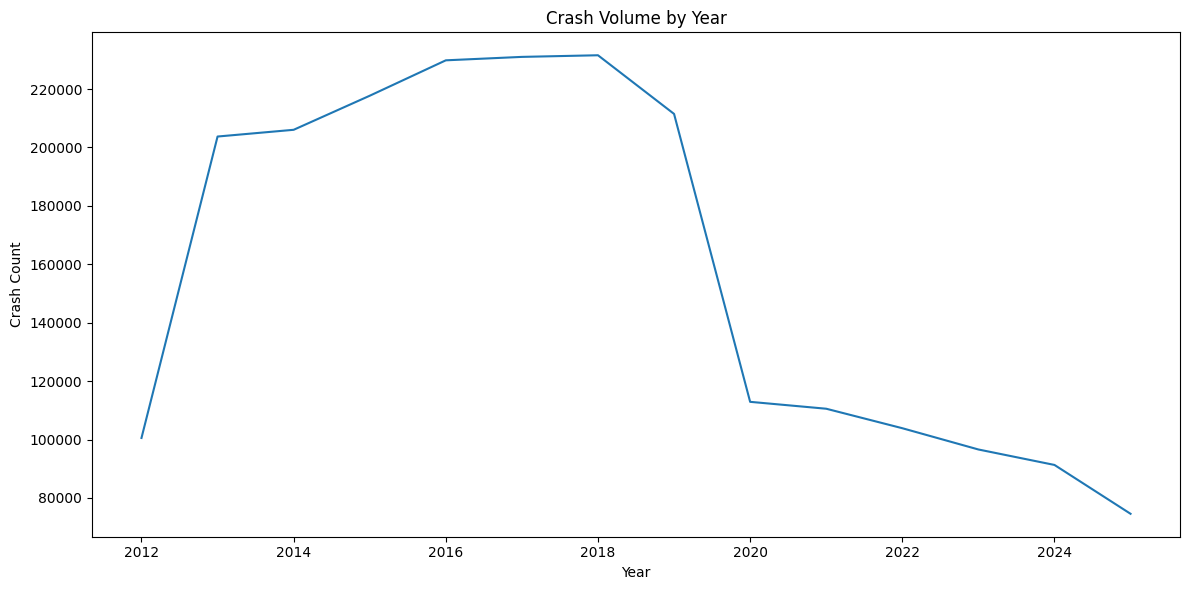

In [24]:
# Crash volume trend by year
crash_volume_by_year = df_crashes.groupby('CRASH YEAR')['COLLISION_ID'].count()

plt.figure(figsize=(12, 6))
sns.lineplot(x=crash_volume_by_year.index, y=crash_volume_by_year.values)
plt.title('Crash Volume by Year')
plt.xlabel('Year')
plt.ylabel('Crash Count')
plt.tight_layout()
plt.show()


Question 2:
How does the rate of collisions change by the hour?

We find that collisions peak between 6pm and 7pm because this is the rush hour in which workers and employees leave work in NYC.

C:\Users\Omnaya\AppData\Local\Temp\ipykernel_15276\366215921.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=hourly_crash, x="CRASH HOUR", y="Number Of Collisions", palette=palette_y)
C:\Users\Omnaya\AppData\Local\Temp\ipykernel_15276\366215921.py:5: UserWarning: 
The palette list has fewer values (1) than needed (24) and will cycle, which may produce an uninterpretable plot.
  sns.barplot(data=hourly_crash, x="CRASH HOUR", y="Number Of Collisions", palette=palette_y)


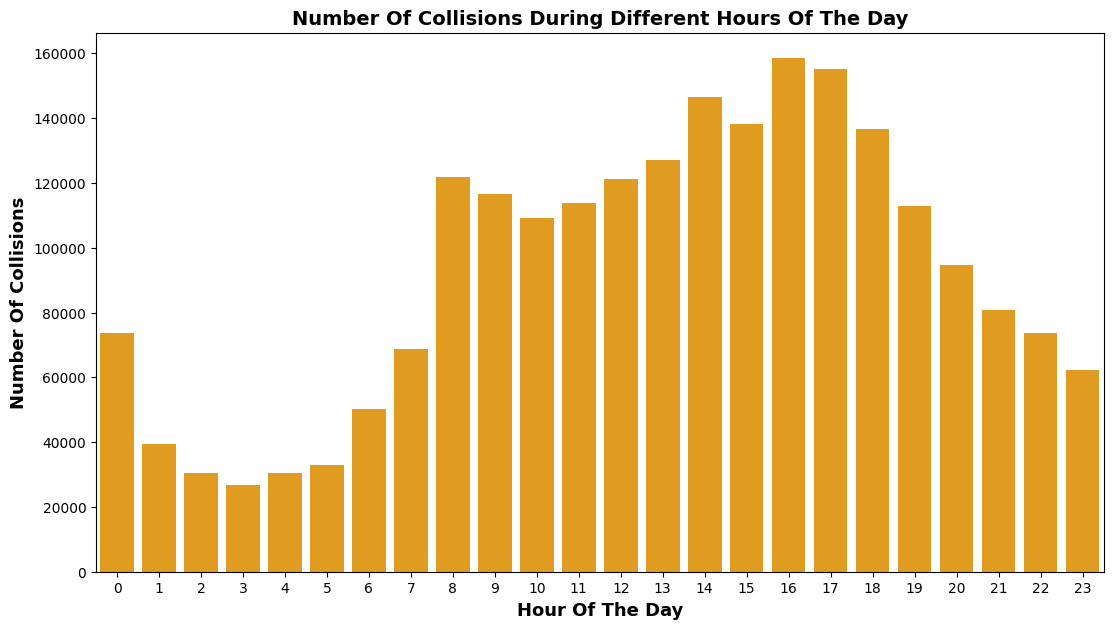

In [25]:
hourly_crash = df_clean.groupby("CRASH HOUR").size().reset_index(name="Number Of Collisions")
palette_x= ["blue"]
palette_y= ["orange"]
plt.figure(figsize=(13,7))
sns.barplot(data=hourly_crash, x="CRASH HOUR", y="Number Of Collisions", palette=palette_y)
plt.ylabel("Number Of Collisions", fontweight="bold", fontsize=13)
plt.xlabel("Hour Of The Day", fontweight="bold", fontsize=13)
plt.title("Number Of Collisions During Different Hours Of The Day",
          fontweight="bold", fontsize=14)

plt.show()

Question 3:
What are the top contributing factors of dangerous collisions?

Driver's attention or distraction is the main factor for a very large number of the collisions.


C:\Users\Omnaya\AppData\Local\Temp\ipykernel_15276\2954777779.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_5_factors.index, y=top_5_factors.values, palette='viridis')


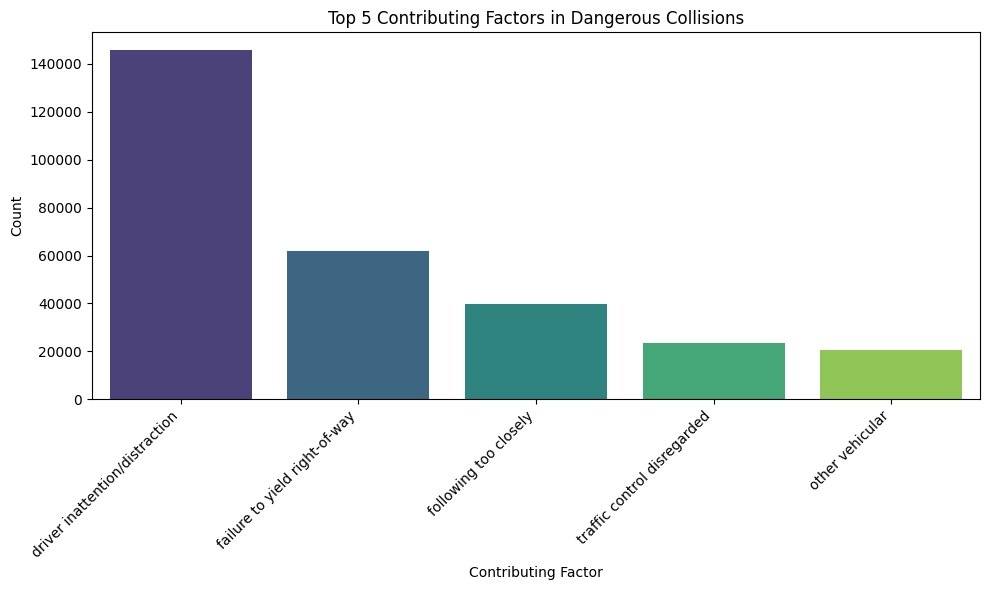

In [26]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Assume df_clean is your initial DataFrame

# Use a more memory-efficient approach to get the top 5 factors
# 1. Filter for dangerous collisions first
dangerous_collisions = df_clean[df_clean['IsDanger'] == 1]

# 2. Melt the two factor columns into a single column called 'Factor'
# This transforms the data from wide to long format.
all_factors = pd.melt(dangerous_collisions, 
                      value_vars=['CONTRIBUTING FACTOR VEHICLE 1', 'CONTRIBUTING FACTOR VEHICLE 2'], 
                      value_name='Factor')

# 3. Remove 'unspecified' values from the new 'Factor' column
all_factors = all_factors[all_factors['Factor'] != 'unspecified']

# 4. Now, perform a single value_counts() to get the top 5 across both original columns
top_5_factors = all_factors['Factor'].value_counts().nlargest(5)

# Plotting remains the same
plt.figure(figsize=(10, 6))
sns.barplot(x=top_5_factors.index, y=top_5_factors.values, palette='viridis')
plt.title('Top 5 Contributing Factors in Dangerous Collisions')
plt.xlabel('Contributing Factor')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


# Persons dataset

In [27]:

df_persons.head()

,UNIQUE_ID,COLLISION_ID,CRASH_DATE,CRASH_TIME,PERSON_ID,PERSON_TYPE,PERSON_INJURY,VEHICLE_ID,PERSON_AGE,EJECTION,...,BODILY_INJURY,POSITION_IN_VEHICLE,SAFETY_EQUIPMENT,PED_LOCATION,PED_ACTION,COMPLAINT,PED_ROLE,CONTRIBUTING_FACTOR_1,CONTRIBUTING_FACTOR_2,PERSON_SEX
0,10249006,4229554,10/26/2019,9:43,31aa2bc0-f545-444f-8cdb-f1cb5cf00b89,Occupant,Unspecified,19141108.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,Registrant,NaN,NaN,U
1,10255054,4230587,10/25/2019,15:15,4629e500-a73e-48dc-b8fb-53124d124b80,Occupant,Unspecified,19144075.0,33.0,Not Ejected,...,Does Not Apply,"Front passenger, if two or more persons, inclu...",Lap Belt & Harness,NaN,NaN,Does Not Apply,Passenger,NaN,NaN,F
2,10253177,4230550,10/26/2019,17:55,ae48c136-1383-45db-83f4-2a5eecfb7cff,Occupant,Unspecified,19143133.0,55.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,Registrant,NaN,NaN,M
3,6650180,3565527,11/21/2016,13:05,2782525,Occupant,Unspecified,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,Notified Person,NaN,NaN,NaN
4,10255516,4231168,10/25/2019,11:16,e038e18f-40fb-4471-99cf-345eae36e064,Occupant,Unspecified,19144329.0,7.0,Not Ejected,...,Does Not Apply,Right rear passenger or motorcycle sidecar pas...,Lap Belt,NaN,NaN,Does Not Apply,Passenger,NaN,NaN,F


In [28]:
print(df_persons.shape)

(5824319, 21)


In [29]:
df_persons.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5824319 entries, 0 to 5824318
Data columns (total 21 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   UNIQUE_ID              int64  
 1   COLLISION_ID           int64  
 2   CRASH_DATE             object 
 3   CRASH_TIME             object 
 4   PERSON_ID              object 
 5   PERSON_TYPE            object 
 6   PERSON_INJURY          object 
 7   VEHICLE_ID             float64
 8   PERSON_AGE             float64
 9   EJECTION               object 
 10  EMOTIONAL_STATUS       object 
 11  BODILY_INJURY          object 
 12  POSITION_IN_VEHICLE    object 
 13  SAFETY_EQUIPMENT       object 
 14  PED_LOCATION           object 
 15  PED_ACTION             object 
 16  COMPLAINT              object 
 17  PED_ROLE               object 
 18  CONTRIBUTING_FACTOR_1  object 
 19  CONTRIBUTING_FACTOR_2  object 
 20  PERSON_SEX             object 
dtypes: float64(2), int64(2), object(17)
memory usage: 933.

In [30]:
print(df_persons.describe(include='all'))

           UNIQUE_ID  COLLISION_ID  CRASH_DATE CRASH_TIME PERSON_ID  \
count   5.824319e+06  5.824319e+06     5824319    5824319   5824300   
unique           NaN           NaN        4888       1440   5629496   
top              NaN           NaN  11/15/2018       0:00         1   
freq             NaN           NaN        4220      87500    142787   
mean    9.377855e+06  4.016873e+06         NaN        NaN       NaN   
std     2.763358e+06  6.650321e+05         NaN        NaN       NaN   
min     1.092200e+04  3.700000e+01         NaN        NaN       NaN   
25%     7.099734e+06  3.705655e+06         NaN        NaN       NaN   
50%     9.575178e+06  4.060966e+06         NaN        NaN       NaN   
75%     1.188763e+07  4.439928e+06         NaN        NaN       NaN   
max     1.353850e+07  4.858610e+06         NaN        NaN       NaN   

       PERSON_TYPE PERSON_INJURY    VEHICLE_ID    PERSON_AGE     EJECTION  \
count      5824319       5824319  5.582697e+06  5.173607e+06      2994

In [31]:
df_persons.columns

Index(['UNIQUE_ID', 'COLLISION_ID', 'CRASH_DATE', 'CRASH_TIME', 'PERSON_ID',
       'PERSON_TYPE', 'PERSON_INJURY', 'VEHICLE_ID', 'PERSON_AGE', 'EJECTION',
       'EMOTIONAL_STATUS', 'BODILY_INJURY', 'POSITION_IN_VEHICLE',
       'SAFETY_EQUIPMENT', 'PED_LOCATION', 'PED_ACTION', 'COMPLAINT',
       'PED_ROLE', 'CONTRIBUTING_FACTOR_1', 'CONTRIBUTING_FACTOR_2',
       'PERSON_SEX'],
      dtype='object')

In [32]:
to_drop = ['CRASH_DATE','CRASH_TIME','VEHICLE_ID']
df_persons_clean = df_persons.drop(to_drop, axis = 1)
df_persons_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5824319 entries, 0 to 5824318
Data columns (total 18 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   UNIQUE_ID              int64  
 1   COLLISION_ID           int64  
 2   PERSON_ID              object 
 3   PERSON_TYPE            object 
 4   PERSON_INJURY          object 
 5   PERSON_AGE             float64
 6   EJECTION               object 
 7   EMOTIONAL_STATUS       object 
 8   BODILY_INJURY          object 
 9   POSITION_IN_VEHICLE    object 
 10  SAFETY_EQUIPMENT       object 
 11  PED_LOCATION           object 
 12  PED_ACTION             object 
 13  COMPLAINT              object 
 14  PED_ROLE               object 
 15  CONTRIBUTING_FACTOR_1  object 
 16  CONTRIBUTING_FACTOR_2  object 
 17  PERSON_SEX             object 
dtypes: float64(1), int64(2), object(15)
memory usage: 799.8+ MB


In [33]:
df_persons_clean.isna().sum()

UNIQUE_ID                      0
COLLISION_ID                   0
PERSON_ID                     19
PERSON_TYPE                    0
PERSON_INJURY                  0
PERSON_AGE                650712
EJECTION                 2829739
EMOTIONAL_STATUS         2732581
BODILY_INJURY            2732538
POSITION_IN_VEHICLE      2829282
SAFETY_EQUIPMENT         3032827
PED_LOCATION             5721807
PED_ACTION               5721908
COMPLAINT                2732531
PED_ROLE                  194889
CONTRIBUTING_FACTOR_1    5723187
CONTRIBUTING_FACTOR_2    5723320
PERSON_SEX                643917
dtype: int64

In [34]:
df_persons_clean["EJECTION"].value_counts()


EJECTION
Not Ejected          2933738
Ejected                29977
Does Not Apply         15888
Partially Ejected      12966
Trapped                 1470
Unknown                  541
Name: count, dtype: int64

For the null values, we decided to:


1.   Replace null values for contributing factors with "Unspecified" cause we have a lot of nulls.
2.   Replace null values for other categorical fetures with "Unkown" cause we have a lot of nulls.
3.   Drop null values for PersonID cause they are very few.
4.   Replace null values for sex with "U"
5.   Replace null values for age with Median



In [35]:

contributing_factors_persons = ['CONTRIBUTING_FACTOR_1', 'CONTRIBUTING_FACTOR_2']
for col in contributing_factors_persons:
    df_persons_clean[col] = df_persons_clean[col].fillna('Unspecified')

categorical_cols_to_fill_unknown = [
    'EJECTION', 'EMOTIONAL_STATUS', 'BODILY_INJURY', 'POSITION_IN_VEHICLE',
    'SAFETY_EQUIPMENT', 'PED_LOCATION', 'PED_ACTION', 'COMPLAINT', 'PED_ROLE'
]
for col in categorical_cols_to_fill_unknown:
    df_persons_clean[col] = df_persons_clean[col].fillna('Unknown')
df_persons_clean['PERSON_SEX'] = df_persons_clean['PERSON_SEX'].fillna('U')
df_persons_clean['PERSON_AGE'] = df_persons_clean['PERSON_AGE'].fillna(df_persons_clean['PERSON_AGE'].median())

df_persons_clean.dropna(subset=['PERSON_ID'], inplace=True)

print(df_persons_clean.isna().sum())

UNIQUE_ID                0
COLLISION_ID             0
PERSON_ID                0
PERSON_TYPE              0
PERSON_INJURY            0
PERSON_AGE               0
EJECTION                 0
EMOTIONAL_STATUS         0
BODILY_INJURY            0
POSITION_IN_VEHICLE      0
SAFETY_EQUIPMENT         0
PED_LOCATION             0
PED_ACTION               0
COMPLAINT                0
PED_ROLE                 0
CONTRIBUTING_FACTOR_1    0
CONTRIBUTING_FACTOR_2    0
PERSON_SEX               0
dtype: int64


In [36]:
# Dropping duplicate rows
df_persons_clean.drop_duplicates(inplace=True)

In [37]:
# Removing outliers: we assume age should be in the range of 0, 125
# Checking number of rows that have age greater than 125 or less than 0 then removing them
print(df_persons_clean[df_persons_clean['PERSON_AGE'] > 125].shape)
print(df_persons_clean[df_persons_clean['PERSON_AGE'] < 0].shape)
df_persons_clean = df_persons_clean[df_persons_clean['PERSON_AGE'] <= 125]
df_persons_clean = df_persons_clean[df_persons_clean['PERSON_AGE'] >= 0]

(3079, 18)
(1296, 18)


Question 4:

Is there a gender that has a higher rate of collisions? Msh asdena 7aga :)

Men have double the number of collisions as Women.

C:\Users\Omnaya\AppData\Local\Temp\ipykernel_15276\1138616843.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=sex_counts.index, y=sex_counts.values, palette='viridis')


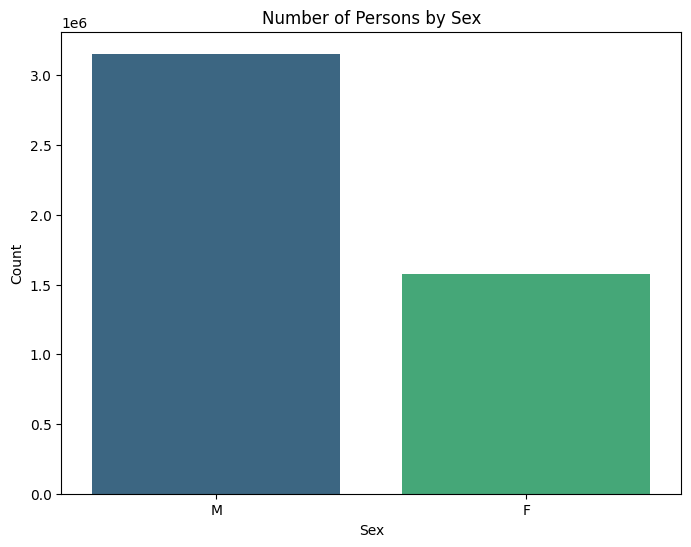

In [ ]:
# Plot bar chart for sex without 'U'
sex_counts = df_persons_clean[df_persons_clean['PERSON_SEX'] != 'U']['PERSON_SEX'].value_counts()
plt.figure(figsize=(8, 6))
sns.barplot(x=sex_counts.index, y=sex_counts.values, palette='viridis')
plt.title('Number of Persons by Sex')
plt.xlabel('Sex')
plt.ylabel('Count')
plt.show()


Question 5: What are the distribution of Persons Involved in Collisions by Age Group?

C:\Users\Omnaya\AppData\Local\Temp\ipykernel_15276\3835005018.py:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=age_distribution.index, y=age_distribution.values, palette='viridis')


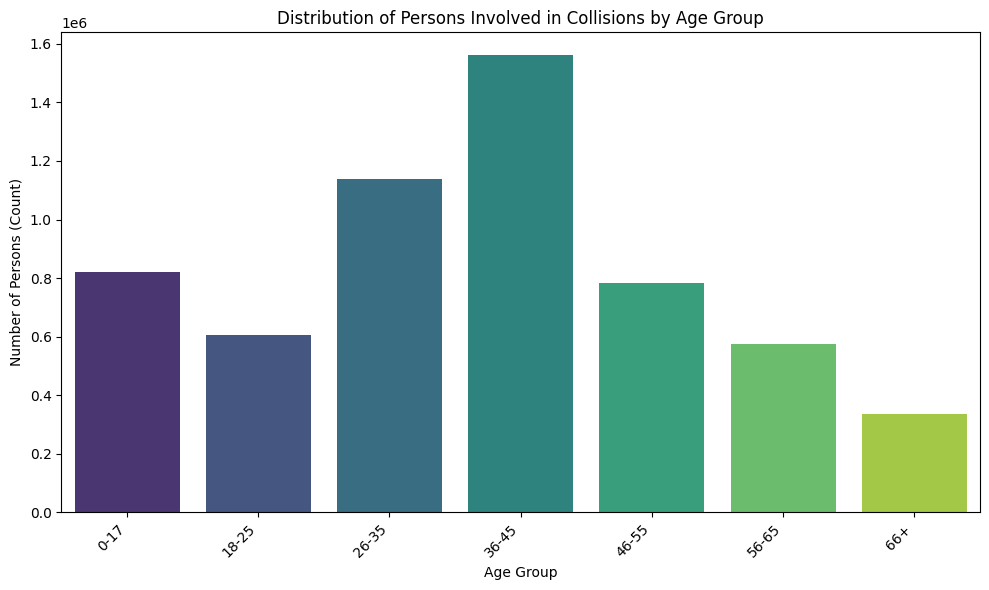

In [39]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Assume df_persons_clean is your initial DataFrame

# 1. Data Preparation: Ensure 'PERSON_AGE' is a numeric type and remove invalid values.
# This prevents errors during binning.
# We convert errors to NaN (Not a Number) and then drop those rows for this analysis.
ages = pd.to_numeric(df_persons_clean['PERSON_AGE'], errors='coerce').dropna()

# 2. Define Age Bins and Labels
# We'll group ages into common demographic categories.
# `right=False` means the bin includes the left edge (e.g., [18, 26) includes 18 but not 26)
bins = [0, 18, 26, 36, 46, 56, 66, np.inf]
labels = ['0-17', '18-25', '26-35', '36-45', '46-55', '56-65', '66+']

# 3. Create the Age Bins using pd.cut
# This function segments and sorts the age data into the bins defined above.
age_bins = pd.cut(ages, bins=bins, labels=labels, right=False)

# 4. Count the number of persons in each age bin
age_distribution = age_bins.value_counts().sort_index()

# 5. Plot the results
plt.figure(figsize=(10, 6))
sns.barplot(x=age_distribution.index, y=age_distribution.values, palette='viridis')
plt.title('Distribution of Persons Involved in Collisions by Age Group')
plt.xlabel('Age Group')
plt.ylabel('Number of Persons (Count)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


We joined the two datasets using an inner join on collision_id

In [40]:
df_merged = pd.merge(df_clean, df_persons_clean, on='COLLISION_ID', how='inner')
print("Shape of the merged DataFrame:", df_merged.shape)
print("First 5 rows of the merged DataFrame:")
print(df_merged.head())

Shape of the merged DataFrame: (5819815, 38)
First 5 rows of the merged DataFrame:
           CRASH DATE  BOROUGH  NUMBER OF PERSONS INJURED  \
0 2021-09-11 02:39:00  UNKNOWN                          2   
1 2021-09-11 02:39:00  UNKNOWN                          2   
2 2021-09-11 02:39:00  UNKNOWN                          2   
3 2021-09-11 02:39:00  UNKNOWN                          2   
4 2022-03-26 11:45:00  UNKNOWN                          1   

   NUMBER OF PERSONS KILLED  NUMBER OF PEDESTRIANS INJURED  \
0                         0                              0   
1                         0                              0   
2                         0                              0   
3                         0                              0   
4                         0                              0   

   NUMBER OF PEDESTRIANS KILLED  NUMBER OF CYCLIST INJURED  \
0                             0                          0   
1                             0                      

Post-Integration Cleaning


In [41]:
print(df_merged.shape)

(5819815, 38)


In [42]:
print(df_merged.info())



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5819815 entries, 0 to 5819814
Data columns (total 38 columns):
 #   Column                         Dtype         
---  ------                         -----         
 0   CRASH DATE                     datetime64[ns]
 1   BOROUGH                        object        
 2   NUMBER OF PERSONS INJURED      int64         
 3   NUMBER OF PERSONS KILLED       int64         
 4   NUMBER OF PEDESTRIANS INJURED  int64         
 5   NUMBER OF PEDESTRIANS KILLED   int64         
 6   NUMBER OF CYCLIST INJURED      int64         
 7   NUMBER OF CYCLIST KILLED       int64         
 8   NUMBER OF MOTORIST INJURED     int64         
 9   NUMBER OF MOTORIST KILLED      int64         
 10  CONTRIBUTING FACTOR VEHICLE 1  object        
 11  CONTRIBUTING FACTOR VEHICLE 2  object        
 12  COLLISION_ID                   int64         
 13  VEHICLE TYPE CODE 1            object        
 14  VEHICLE TYPE CODE 2            object        
 15  CRASH YEAR     

In [43]:
print(df_merged.isnull().sum())


CRASH DATE                       0
BOROUGH                          0
NUMBER OF PERSONS INJURED        0
NUMBER OF PERSONS KILLED         0
NUMBER OF PEDESTRIANS INJURED    0
NUMBER OF PEDESTRIANS KILLED     0
NUMBER OF CYCLIST INJURED        0
NUMBER OF CYCLIST KILLED         0
NUMBER OF MOTORIST INJURED       0
NUMBER OF MOTORIST KILLED        0
CONTRIBUTING FACTOR VEHICLE 1    0
CONTRIBUTING FACTOR VEHICLE 2    0
COLLISION_ID                     0
VEHICLE TYPE CODE 1              0
VEHICLE TYPE CODE 2              0
CRASH YEAR                       0
CRASH MONTH                      0
CRASH MONTH NAME                 0
CRASH HOUR                       0
CRASH WEEK                       0
IsDanger                         0
UNIQUE_ID                        0
PERSON_ID                        0
PERSON_TYPE                      0
PERSON_INJURY                    0
PERSON_AGE                       0
EJECTION                         0
EMOTIONAL_STATUS                 0
BODILY_INJURY       

In [44]:
print(df_merged.describe(include='all'))


                           CRASH DATE  BOROUGH  NUMBER OF PERSONS INJURED  \
count                         5819815  5819815               5.819815e+06   
unique                            NaN        6                        NaN   
top                               NaN  UNKNOWN                        NaN   
freq                              NaN  2153140                        NaN   
mean    2019-08-07 02:01:09.778837760      NaN               5.242572e-01   
min               2012-07-01 00:05:00      NaN               0.000000e+00   
25%               2017-06-29 23:55:30      NaN               0.000000e+00   
50%               2019-01-09 13:50:00      NaN               0.000000e+00   
75%               2021-07-20 12:08:00      NaN               1.000000e+00   
max               2025-11-17 23:26:00      NaN               4.300000e+01   
std                               NaN      NaN               1.052139e+00   

        NUMBER OF PERSONS KILLED  NUMBER OF PEDESTRIANS INJURED  \
count   

In [45]:
print(df_merged.duplicated().sum())

0


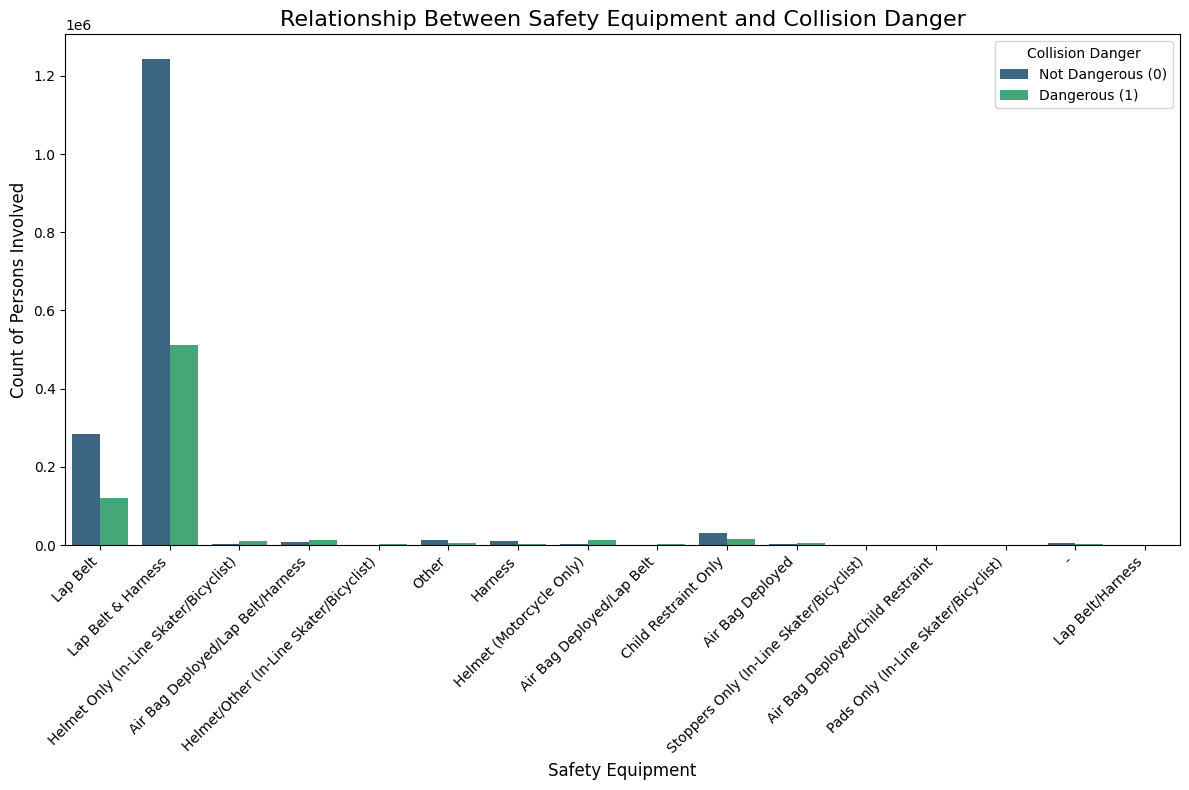

In [47]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Assume df_persons_clean is your initial DataFrame

# 1. Filter out 'Unknown' values from the 'SAFETY_EQUIPMENT' column.
# We also handle other potential "unknown" variations like 'UNSPECIFIED'.
unknown_values = ['Unknown', 'UNSPECIFIED']
df_filtered = df_merged[~df_merged['SAFETY_EQUIPMENT'].isin(unknown_values)]

# 2. Create the plot.
# A countplot is perfect for showing the number of occurrences.
plt.figure(figsize=(12, 8))
sns.countplot(
    x='SAFETY_EQUIPMENT', 
    hue='IsDanger', 
    data=df_filtered, 
    palette='viridis'
)

# 3. Add titles and labels for clarity.
plt.title('Relationship Between Safety Equipment and Collision Danger', fontsize=16)
plt.xlabel('Safety Equipment', fontsize=12)
plt.ylabel('Count of Persons Involved', fontsize=12)

# 4. Improve readability of the x-axis labels.
plt.xticks(rotation=45, ha='right')

# 5. Adjust the legend.
# The default 'IsDanger' legend might just show 0 and 1. We can make it more descriptive.
handles, labels = plt.gca().get_legend_handles_labels()
plt.legend(handles, ['Not Dangerous (0)', 'Dangerous (1)'], title='Collision Danger')

plt.tight_layout()
plt.show()


Data looks good with no duplicates and not that many nulls so we will not be changing anything.

Which vehicle types are most frequently involved in accidents with cyclists?

C:\Users\Omnaya\AppData\Local\Temp\ipykernel_15276\3291264467.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


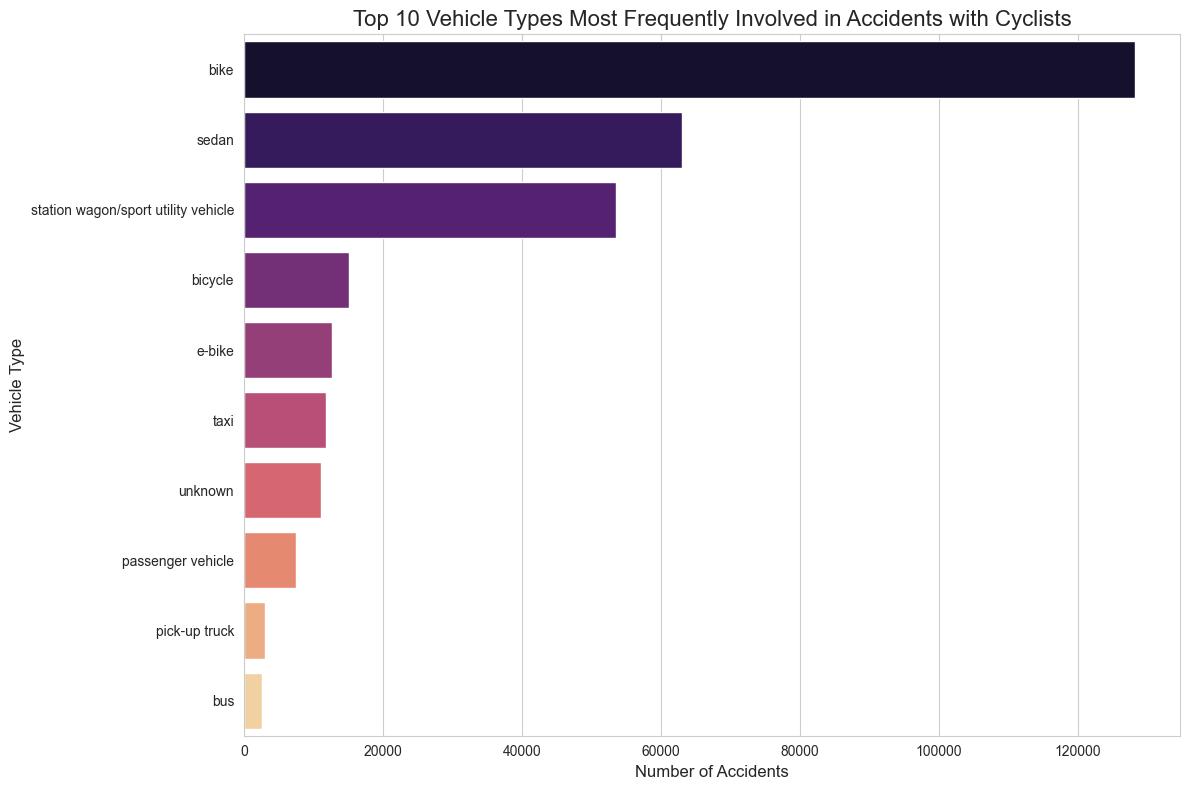

In [50]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Set the aesthetic style of the plots
sns.set_style("whitegrid")

# Filter the DataFrame to include only accidents where at least one cyclist was injured or killed.
cyclist_accidents_df = df_merged[(df_merged['NUMBER OF CYCLIST INJURED'] > 0) | (df_merged['NUMBER OF CYCLIST KILLED'] > 0)].copy()

# Combine the vehicle type columns to get a single list of all vehicles involved in these accidents.
# We use pd.concat to stack 'VEHICLE TYPE CODE 1' and 'VEHICLE TYPE CODE 2'.
vehicles_involved = pd.concat(
    [cyclist_accidents_df['VEHICLE TYPE CODE 1'], cyclist_accidents_df['VEHICLE TYPE CODE 2']],
    ignore_index=True
)

# Count the occurrences of each vehicle type and get the top 10.
# We drop null values and filter out any 'Unknown' types for a cleaner chart.
top_vehicle_types = vehicles_involved.dropna().loc[lambda x: x != 'Unknown'].value_counts().nlargest(10)

# Create a figure and axes for the plot
plt.figure(figsize=(12, 8))

# Generate the horizontal bar plot
sns.barplot(
    x=top_vehicle_types.values,
    y=top_vehicle_types.index,
    orient='h',
    palette='magma'
)

# Add titles and labels for clarity
plt.title('Top 10 Vehicle Types Most Frequently Involved in Accidents with Cyclists', fontsize=16)
plt.xlabel('Number of Accidents', fontsize=12)
plt.ylabel('Vehicle Type', fontsize=12)

# Adjust layout to prevent labels from being cut off
plt.tight_layout()

# Display the plot
plt.show()

In [48]:
# Convert the column to string to handle both numbers and 'Unknown'
#df_merged['VEHICLE_ID'] = df_merged['VEHICLE_ID'].astype(str)

# Use Parquet instead of CSV. It is much faster and smaller,
# keeping your repo size low (GitHub has a 100MB limit).
# Now try saving again
df_merged.to_parquet('crashes.parquet')

In [49]:
import pandas as pd

# Load the file
df = pd.read_parquet('crashes.parquet')

# Print all column names
print("\n--- COLUMN NAMES IN YOUR FILE ---")
print(df.columns.tolist())
print("---------------------------------\n")


--- COLUMN NAMES IN YOUR FILE ---
['CRASH DATE', 'BOROUGH', 'NUMBER OF PERSONS INJURED', 'NUMBER OF PERSONS KILLED', 'NUMBER OF PEDESTRIANS INJURED', 'NUMBER OF PEDESTRIANS KILLED', 'NUMBER OF CYCLIST INJURED', 'NUMBER OF CYCLIST KILLED', 'NUMBER OF MOTORIST INJURED', 'NUMBER OF MOTORIST KILLED', 'CONTRIBUTING FACTOR VEHICLE 1', 'CONTRIBUTING FACTOR VEHICLE 2', 'COLLISION_ID', 'VEHICLE TYPE CODE 1', 'VEHICLE TYPE CODE 2', 'CRASH YEAR', 'CRASH MONTH', 'CRASH MONTH NAME', 'CRASH HOUR', 'CRASH WEEK', 'IsDanger', 'UNIQUE_ID', 'PERSON_ID', 'PERSON_TYPE', 'PERSON_INJURY', 'PERSON_AGE', 'EJECTION', 'EMOTIONAL_STATUS', 'BODILY_INJURY', 'POSITION_IN_VEHICLE', 'SAFETY_EQUIPMENT', 'PED_LOCATION', 'PED_ACTION', 'COMPLAINT', 'PED_ROLE', 'CONTRIBUTING_FACTOR_1', 'CONTRIBUTING_FACTOR_2', 'PERSON_SEX']
---------------------------------



## Question 1: Accident Severity Across Different Boroughs

**Research Question:** How does the severity of accidents vary across different boroughs?

**Columns:** BOROUGH, NUMBER OF PERSONS INJURED, NUMBER OF PERSONS KILLED

**Goal:** To see if certain boroughs have "deadlier" accidents than others, rather than just a higher volume of accidents.

**Visualization:** A Grouped Bar Chart comparing the average number of injuries vs. deaths per borough.


In [59]:
# Question 1: Accident Severity Across Different Boroughs
# Memory-efficient approach: Select only needed columns first, then get unique collisions
print("Getting unique collisions (this may take a moment)...")

# Select only the columns we need for this analysis
cols_needed = ['COLLISION_ID', 'BOROUGH', 'NUMBER OF PERSONS INJURED', 'NUMBER OF PERSONS KILLED']
df_subset = df_merged[cols_needed].copy()

# Use groupby().first() instead of drop_duplicates() - more memory efficient
collisions_unique = df_subset.groupby('COLLISION_ID').first().reset_index()

# Filter out missing borough values (now on much smaller dataset)
valid_borough_mask = collisions_unique['BOROUGH'].notna() & (collisions_unique['BOROUGH'] != '')
borough_severity = collisions_unique.loc[valid_borough_mask].copy()

# Group by borough and calculate average injuries and deaths per accident
borough_stats = borough_severity.groupby('BOROUGH').agg({
    'NUMBER OF PERSONS INJURED': 'mean',
    'NUMBER OF PERSONS KILLED': 'mean',
    'COLLISION_ID': 'count'  # Total number of accidents per borough
}).round(3)

borough_stats.columns = ['Avg_Injuries', 'Avg_Deaths', 'Total_Accidents']

# Sort by average deaths (descending) to see which boroughs have deadlier accidents
borough_stats = borough_stats.sort_values('Avg_Deaths', ascending=False)

print("Average Injuries and Deaths per Accident by Borough:")
print(borough_stats)
print(f"\nTotal unique collisions analyzed: {len(borough_severity):,}")


Getting unique collisions (this may take a moment)...
Average Injuries and Deaths per Accident by Borough:
               Avg_Injuries  Avg_Deaths  Total_Accidents
BOROUGH                                                 
STATEN ISLAND         0.465       0.003            41773
UNKNOWN               0.470       0.003           528093
BROOKLYN              0.490       0.002           353206
BRONX                 0.469       0.002           168915
QUEENS                0.453       0.002           290341
MANHATTAN             0.372       0.002           209129

Total unique collisions analyzed: 1,591,457


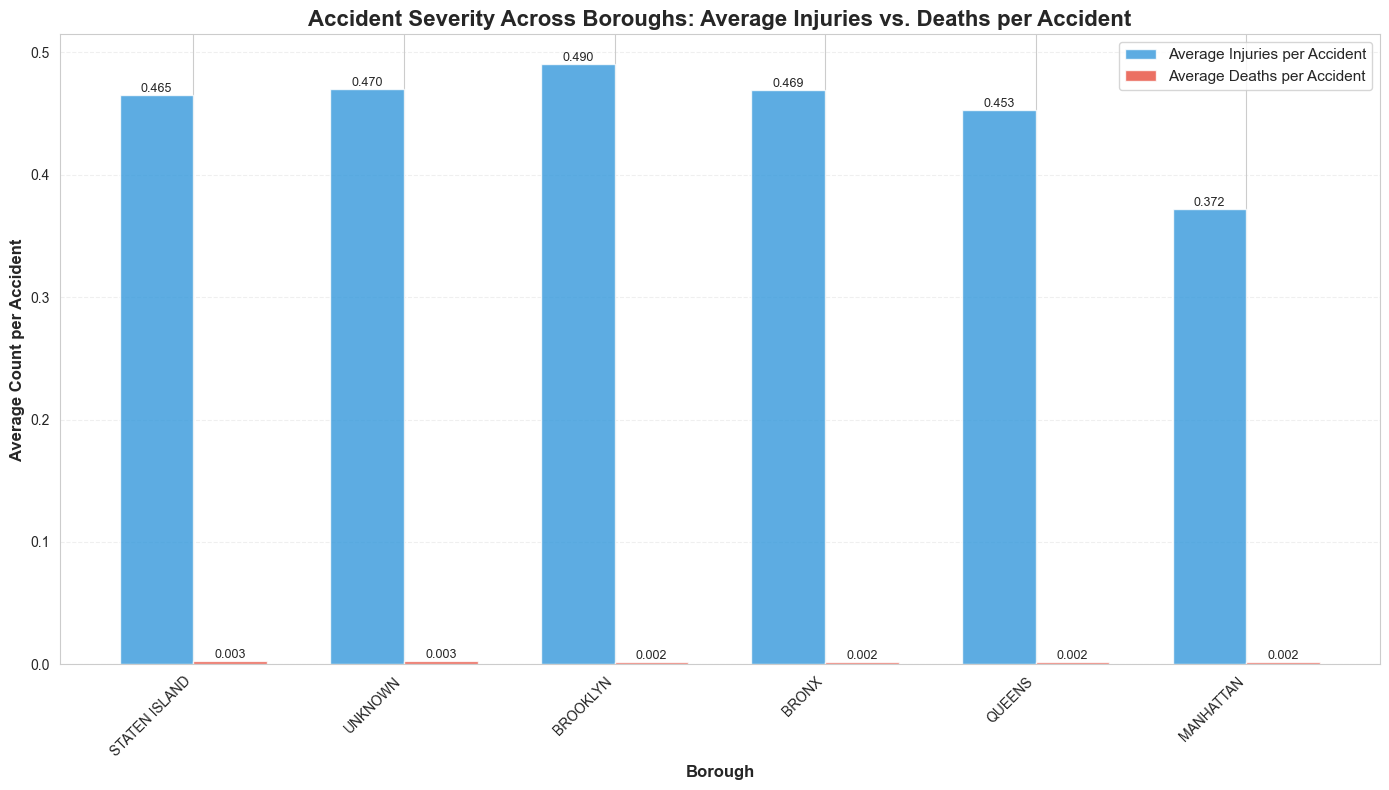


=== Key Insights ===
Borough with highest average injuries per accident: BROOKLYN (0.490)
Borough with highest average deaths per accident: STATEN ISLAND (0.003)

Note: This shows severity (average per accident), not total volume.
Borough with most total accidents: UNKNOWN (528,093 accidents)


In [60]:
# Grouped Bar Chart: Average Injuries vs. Deaths per Borough
boroughs = borough_stats.index
avg_injuries = borough_stats['Avg_Injuries']
avg_deaths = borough_stats['Avg_Deaths']

# Set up the figure and axis
fig, ax = plt.subplots(figsize=(14, 8))

# Set the width of the bars
x = np.arange(len(boroughs))
width = 0.35

# Create the bars
bars1 = ax.bar(x - width/2, avg_injuries, width, label='Average Injuries per Accident', 
               color='#3498db', alpha=0.8)
bars2 = ax.bar(x + width/2, avg_deaths, width, label='Average Deaths per Accident', 
               color='#e74c3c', alpha=0.8)

# Add value labels on bars
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.3f}',
                ha='center', va='bottom', fontsize=9)

# Customize the chart
ax.set_xlabel('Borough', fontsize=12, fontweight='bold')
ax.set_ylabel('Average Count per Accident', fontsize=12, fontweight='bold')
ax.set_title('Accident Severity Across Boroughs: Average Injuries vs. Deaths per Accident', 
             fontsize=16, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(boroughs, rotation=45, ha='right')
ax.legend(fontsize=11)
ax.grid(axis='y', alpha=0.3, linestyle='--')

plt.tight_layout()
plt.show()

# Additional insights
print("\n=== Key Insights ===")
print(f"Borough with highest average injuries per accident: {borough_stats['Avg_Injuries'].idxmax()} "
      f"({borough_stats['Avg_Injuries'].max():.3f})")
print(f"Borough with highest average deaths per accident: {borough_stats['Avg_Deaths'].idxmax()} "
      f"({borough_stats['Avg_Deaths'].max():.3f})")
print(f"\nNote: This shows severity (average per accident), not total volume.")
print(f"Borough with most total accidents: {borough_stats['Total_Accidents'].idxmax()} "
      f"({borough_stats['Total_Accidents'].max():,} accidents)")


## Question 2: Most Common Pedestrian Actions Leading to Accidents

**Research Question:** What are the most common pedestrian actions leading to accidents?

**Columns:** PED_ACTION, NUMBER OF PEDESTRIANS INJURED

**Goal:** To understand behavior patterns. For example, are more pedestrians hit while "Crossing with Signal" or "Coming from Behind Parked Vehicle"?

**Visualization:** A Horizontal Bar Chart of the PED_ACTION counts, filtered for cases where injuries occurred.


In [55]:
# Question 2: Most Common Pedestrian Actions Leading to Accidents
# Filter for cases where pedestrians were injured
pedestrian_injuries = df_merged[df_merged['NUMBER OF PEDESTRIANS INJURED'] > 0].copy()

# Filter out missing values and 'Unknown' entries for cleaner analysis
pedestrian_actions = pedestrian_injuries[pedestrian_injuries['PED_ACTION'].notna() & 
                                         (pedestrian_injuries['PED_ACTION'] != 'Unknown') &
                                         (pedestrian_injuries['PED_ACTION'] != '')].copy()

# Count the occurrences of each pedestrian action
action_counts = pedestrian_actions['PED_ACTION'].value_counts()

print(f"Total accidents with pedestrian injuries: {len(pedestrian_injuries):,}")
print(f"Accidents with valid PED_ACTION data: {len(pedestrian_actions):,}")
print(f"\nTop 15 Most Common Pedestrian Actions Leading to Injuries:")
print(action_counts.head(15))


Total accidents with pedestrian injuries: 302,915
Accidents with valid PED_ACTION data: 87,339

Top 15 Most Common Pedestrian Actions Leading to Injuries:
PED_ACTION
Crossing With Signal                               35808
Crossing, No Signal, or Crosswalk                  15742
Crossing, No Signal, Marked Crosswalk               8302
Other Actions in Roadway                            6603
Crossing Against Signal                             6118
Not in Roadway                                      4342
Does Not Apply                                      3456
Emerging from in Front of/Behind Parked Vehicle     2810
Working in Roadway                                  1269
Getting On/Off Vehicle Other Than School Bus        1259
Riding/Walking Along Highway With Traffic            596
Playing in Roadway                                   516
Pushing/Working on Car                               231
Riding/Walking Along Highway Against Traffic         214
Going to/From Stopped School Bus    

C:\Users\Omnaya\AppData\Local\Temp\ipykernel_15276\1979009425.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


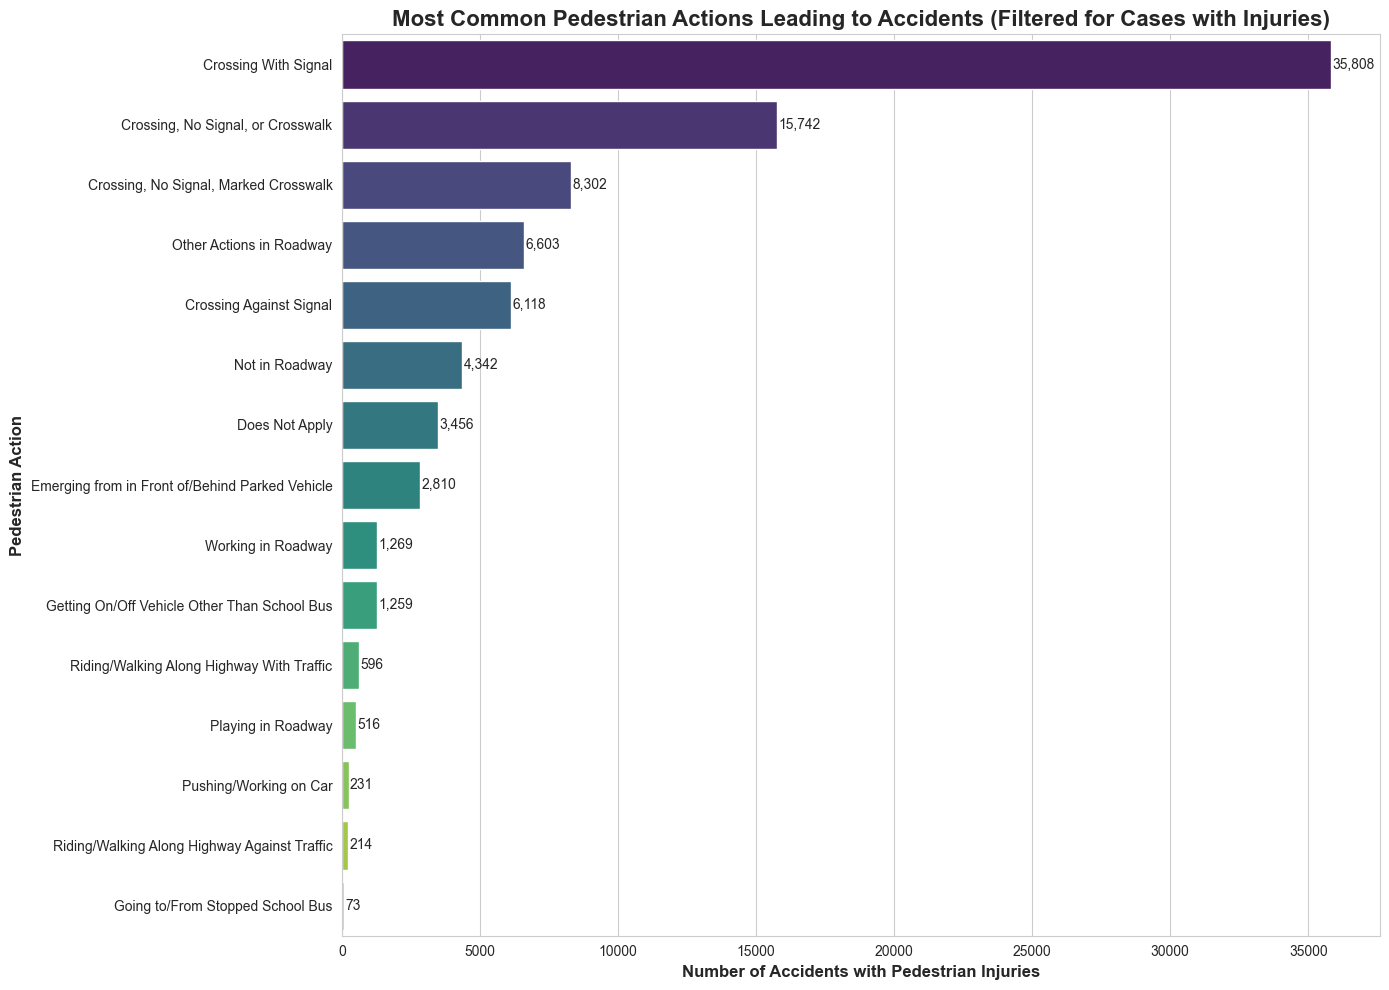


=== Summary Statistics ===
Total unique pedestrian actions: 15
Most common action: 'Crossing With Signal' with 35,808 occurrences
Percentage of total: 41.00%


In [56]:
# Horizontal Bar Chart: Most Common Pedestrian Actions Leading to Accidents
# Get top actions (limit to top 15 for readability)
top_actions = action_counts.head(15)

# Create figure and axes
plt.figure(figsize=(14, 10))

# Generate the horizontal bar plot
sns.barplot(
    x=top_actions.values,
    y=top_actions.index,
    orient='h',
    palette='viridis'
)

# Add titles and labels
plt.title('Most Common Pedestrian Actions Leading to Accidents (Filtered for Cases with Injuries)', 
          fontsize=16, fontweight='bold')
plt.xlabel('Number of Accidents with Pedestrian Injuries', fontsize=12, fontweight='bold')
plt.ylabel('Pedestrian Action', fontsize=12, fontweight='bold')

# Add value labels on bars
for i, v in enumerate(top_actions.values):
    plt.text(v + 50, i, f'{v:,}', va='center', fontsize=10)

# Adjust layout
plt.tight_layout()
plt.show()

# Summary statistics
print(f"\n=== Summary Statistics ===")
print(f"Total unique pedestrian actions: {len(action_counts)}")
print(f"Most common action: '{action_counts.index[0]}' with {action_counts.iloc[0]:,} occurrences")
print(f"Percentage of total: {(action_counts.iloc[0] / len(pedestrian_actions) * 100):.2f}%")


## Question 4: Relationship between Ejection and Bodily Injury Severity

**Research Question:** What is the relationship between being ejected from a vehicle and the severity of bodily injury?



In [51]:
# Question 4: Relationship between Ejection and Bodily Injury Severity
# Filter out missing values and 'Unknown' entries for cleaner analysis
ejection_injury_data = df_merged[['EJECTION', 'BODILY_INJURY']].copy()
ejection_injury_data = ejection_injury_data[
    (ejection_injury_data['EJECTION'].notna()) & 
    (ejection_injury_data['EJECTION'] != 'Unknown') &
    (ejection_injury_data['BODILY_INJURY'].notna()) & 
    (ejection_injury_data['BODILY_INJURY'] != 'Unknown')
]

# Create a crosstab to show the relationship
crosstab = pd.crosstab(ejection_injury_data['EJECTION'], ejection_injury_data['BODILY_INJURY'], normalize='index') * 100

print("Proportion of Bodily Injury Types by Ejection Status (%):")
print(crosstab.round(2))
print(f"\nTotal records analyzed: {len(ejection_injury_data):,}")


Proportion of Bodily Injury Types by Ejection Status (%):
BODILY_INJURY      Abdomen - Pelvis  Back  Chest  Does Not Apply  \
EJECTION                                                           
Does Not Apply                 0.26  1.44   0.31           87.91   
Ejected                        1.39  5.54   1.40            9.49   
Not Ejected                    0.24  2.75   0.61           86.61   
Partially Ejected              1.16  4.50   1.11           37.47   
Trapped                        1.35  4.91   3.13           35.09   

BODILY_INJURY      Elbow-Lower-Arm-Hand  Entire Body   Eye  Face   Head  \
EJECTION                                                                  
Does Not Apply                     0.91         0.89  0.03  0.42   1.83   
Ejected                           10.30        10.81  0.17  4.54  17.43   
Not Ejected                        0.83         1.15  0.03  0.35   1.90   
Partially Ejected                  8.81         4.97  0.09  2.65   7.60   
Trapped        

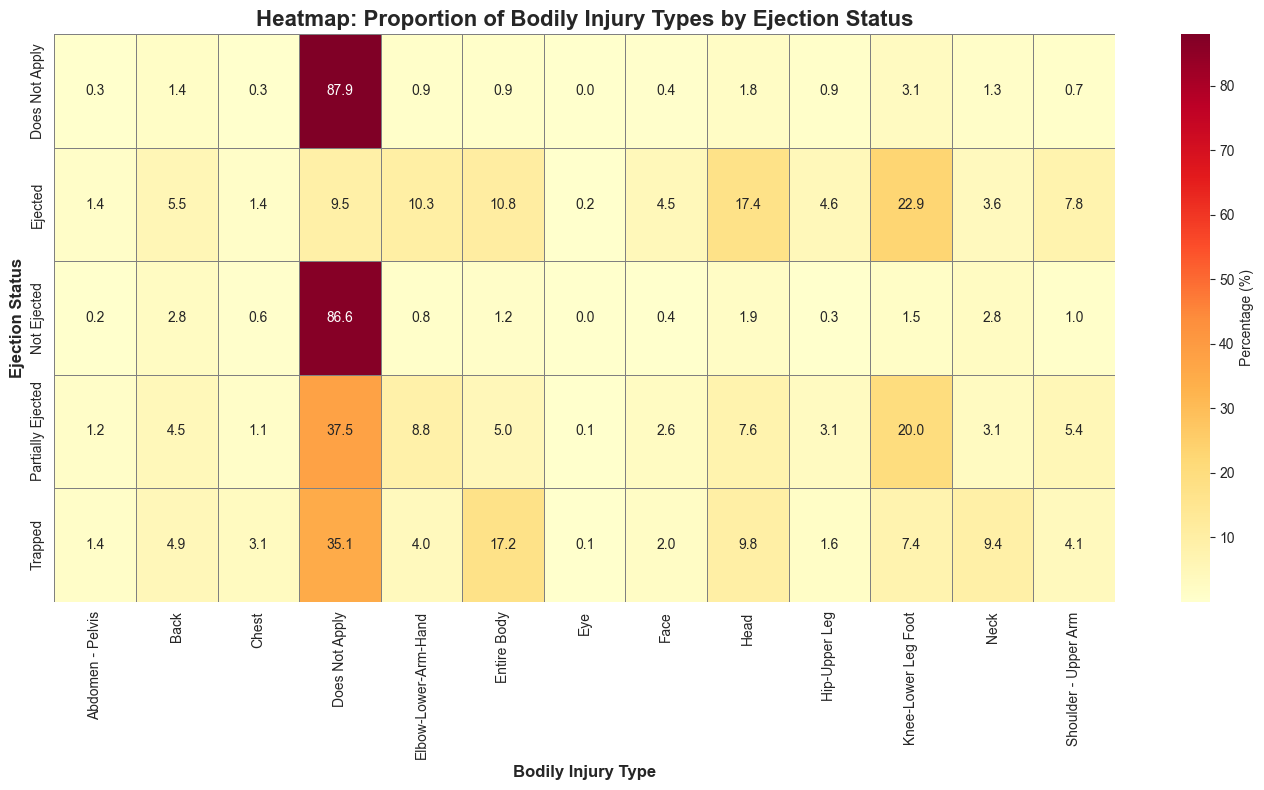

In [52]:
# Heatmap: Relationship between Ejection and Bodily Injury Severity
plt.figure(figsize=(14, 8))
sns.heatmap(
    crosstab, 
    annot=True, 
    fmt='.1f', 
    cmap='YlOrRd', 
    cbar_kws={'label': 'Percentage (%)'},
    linewidths=0.5,
    linecolor='gray'
)
plt.title('Heatmap: Proportion of Bodily Injury Types by Ejection Status', fontsize=16, fontweight='bold')
plt.xlabel('Bodily Injury Type', fontsize=12, fontweight='bold')
plt.ylabel('Ejection Status', fontsize=12, fontweight='bold')
plt.tight_layout()
plt.show()
